## DonorsChoose- Part 3. Ranking Algorithm & Intuitions

#### The purpose of this notebook is to explain the intuition behind the e-mail recommendation system, why the donor's behaviors support this approach, and the performance of the ranking algorithm.  

This notebook is Part 3 of 3 notebooks.  Part 1 focuses on Feature Engineering, Part 2 focuses on Data Exploration, and Part 3 focuss on building the recommender system and evaluating the model.  

<a href='#1'>1. Introduction</a><br>
<a href='#2'>2. Why does the ranking system work?</a><br>
<a href='#3'>3. Building the Recommender</a><br>
<a href='#4'>4. Example of the Recommender Output</a><br>
<a href='#5'>5. Recommender Performance</a><br>
<a href='#6'>6. Causes of underformance and how to improve the model?</a><br>
<a href='#7'>7. Future Enhancements</a><br>

### <a id='1'>1. Introduction</a>

#### Background
DonorsChoose.org is an organization that helps teachers fundraise for American classrooms.  The goal of the project is to enable DonorsChoose.org to build targeted email campaigns recommending specific classroom requests to prior donors.  The organization has supplied anonymized [data](https://www.kaggle.com/donorschoose/io) on donor giving from the past five years, starting from January 2013 to May 1, 2018.   

In Part 1 of the notebooks, features were generated to capture the characteristics regarding the donors, the schools, as well as the projects.  The features related to donors are normalized to reflect an donor's interest relative to the rest of the donors. The project features are one-hot encoded.  A major feature that proved to be very useful is geographic location of the donor and the schools.  A main component of the reommendation algorithm is Geo Search, where possible recommendations are filtered and sorted by distance or around certain geo-locations.

#### Recommendation Algorithm
The recommendation algorithm is based on a combination of Filtering and Ranking.  Here are the implementation steps:
<Br>
Prepare Project Features Matrix and Donor Features Matrix

1. Generate the Project Features Matrix: The project features are the encodings of the project characteristics, such as the project category, school metro type, project grade level, project resource, the percentage of students receiving free lunch, and etc. Some features are one-hot encoded, and some are binned. There are a total of 71 dimensions. (details are discussed in Part 1 of the Notebooks)

2. Generate the Donor Features Matrix: The Donor Features Matrix not only has features that measures the donor's interest in every metrics in the Project Features Matrix, but it includes donation history based features.  Some examples of the donation based features include statistics for the number of carts, projects, schools, & teachers that the the donor had ever donated to, and the distance features between the school location and the donor location.  Additionally, The features in the Donor Features Matrix are normalized either by comparing the donor to the the mean of all the donors, or are based on the percentile ranking against the other donors. There are a total of 96 dimensions.  (details are discussed in Part 1 of the Notebooks)


Filtering
1. Obtain projects that are eligible for recommendations, which would be projects that are not yet fully funded, and have not expired. We will refer to these projects as the "Initial Project Universe." 
2. Next, we will narrow down the "Initial Project Universe."  We will refer to the remaining projects as the "Project Universe." The criterias in determining the Project Universe are as follows:
    1. Obtain the "School City, School State" of the projects that the donor has ever donated to in the past, and filter the "Initial Project Universe" by these locations. 
    2. Obtain projects in the "Initial Project Universe" that are located in the donor's "Donor City, Donor State".
    3. Obtain the "Teacher IDs" that the donor has ever donated to in the past, and filter the "Initial Project Universe" by these "Teacher IDs"<br>
    
3. The Project Features Matrix that will be used to calculate similarity score between the donor and the projects, will only include the projects obtained above, and these are also the projects that we will rank.

Ranking<br>
The relevance of a project is based on the following attributes: <br>
1. Calculate the Similarity Score between the Project Features Matrix and the corresponding features in the Donor Features Matrix by taking the dot product between the two.

2. The Final Score is based on a combination of:
    1. Similarity Score calculated from step 1.  
    2. School Bonus: +1 point if the project is from a school that the donor has previously donated to
    3. Teacher Bonus: +1 point if the project is from a teacher that the donor has previously donated to 
    4. Home City Bonus: +1 point if the project is located in the Donor City.   
    5. Project Location Bonus: +1 point if the project is located in a city that the donor has previously donated to
    6. Frequent Location Bonus: Reward the projects that are originated from the cities that the donor has made the most contribution to in the past (based on dollar amount). The rational behind this bonus is that the likelihood of the donor donating to these cities again is higher than the likelihood of the donor donating to the other cities. <br> 
    <br>To calculate the Frequent Location Bonus, you would multiply the sum of A+B+C+D+E by a scaling factor. The scaling factor is designed in such as a way that the effect of the boost will be higher as the donor donates to more city.  The boost will be minimal if the donor has only donated to a few cities.
    
    *Example:* 
    <br>A location ranked #1 will receive a boost of 0.5 if the donor have donated to 50 cities.  The boost will decrease to 0.1 if the donor have only donated to 10 cities.  
    
    *Formula: *
    $$scaling\:factor =\frac{1}{100}*\frac{Number\:of\:Cities}{City\:Ranking\:(highest\:ranks\:No.1)}$$
    
    **Ranking Score Calculation:** <br>
    Preliminary score = similarity score + school bonus + teacher bonus + home city bonus + project location bonus<br>
    Frequent Location bonus = scaling factor x Preliminary score <br>
    Final score = Preliminary score + Frequent location bonus <br>

#### Validation Scheme
Use data prior to 2018 (2013-2017) to generate the Donor Features Matrix.  Validate model recommendations against the donations occuring in the month of January 2018.  This validation scheme avoids the look-ahead bias. Below summarizes the scope of the validation sets:<br>
* Number of donors who donated prior to 2018 and in January 2018: 31,362
* Number of projects that donors donated to in January 2018: 32,716
* Number of projects that donors can choose from (projects that expires after Dec. 31, 2017): 47,816


#### Result

5000 random sample of donors are drawn from the pool of 31,362 donors: <br>
With 47,816 projects to choose from, the recommender was able to recommend the correct project 34% of times as the top-1 project.<br>
* % Hit in top 1 Recommendations: 34%
* % Hit in top 5 Recommendations: 55%
* % Hit in top 10 Recommendations: 61%
* % Hit in top 25 Recommendations: 68%

#### The Analysis below shows why location, school, teacher, and Owner Interest are used as the criterias.

In [1]:
import numpy as np
import pandas as pd 
import os
import datetime as dt
import pickle
import gc
from sklearn import cluster
import seaborn as sns
import matplotlib.pyplot as plt
import plotly as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
py.offline.init_notebook_mode(connected=True)
%matplotlib inline

In [2]:
schools= pd.read_pickle('schools.pkl')
donors= pd.read_pickle('donors.pkl')
projects= pd.read_pickle('projects.pkl')
donations= pd.read_pickle('donations.pkl')

projFeatures = pd.read_pickle('projFeatures.pkl') 
dist = pd.read_pickle('dist.pkl')
distFeatures = pd.read_pickle('distFeatures.pkl')


donorSummary = pd.read_pickle('donorSummary.pkl') # prior to 2018
donorInterest = pd.read_pickle('donorInterest.pkl') # prior to 2018
donorFeatureMatrixNoAdj = pd.read_pickle('donorFeatureMatrixNoAdj.pkl') #prior to 2018
donorFeatureMatrix = pd.read_pickle('donorFeatureMatrix.pkl') # prior to 2018

### <a id='2'>2. Why does the ranking system work?</a>

### Donors tend to donate to the same schools

#### 81% of the donors who have donated to more than one project, have donated to the same school
Donors have a tendancy to donate to selected schools. By comparing the count of projects that the donor has donated to against the number of schools, we can see that the school count is lower.  This means that the donor has has donated to the same school at least once. <br>
Some possible explanations of this phenomenon could be that the donors prefer to donate to local schools, or donate to schools where their family attend.  

True     0.814897
False    0.185103
Name: School Bias, dtype: float64

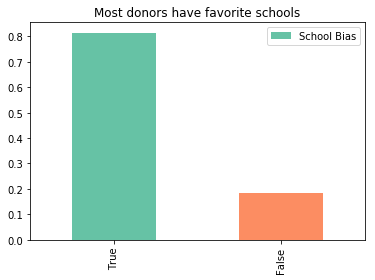

In [3]:
sns.set_palette("Set2")
chartData = donorSummary.loc[donorSummary['num_proj']>1]
chartData['School Bias'] = chartData['School ID_count'] < chartData['num_proj']
Breakdown = chartData['School Bias'].value_counts()/len(chartData)
Breakdown.plot(kind='bar', stacked=True, legend = True)
plt.title("Most donors have favorite schools")
Breakdown


Another way to quantify the preference for one school is to meaure the concentration of school donation.  If a donor has donated to 5 schools, totaling `$`1,000 and `$`900 went to one single school, the concentration would be 90%.  Suppose the donation is evenly distributed (`$`200 each) between the 5 schools, the concentration would be 20%. The bias could be captured by the difference between the calculated concentration v.s. the evenly distributed concentration.  

Looking at the chart below:
* The pink line has a slope of 1.  Donors who donated equally amongst all the schools would lie on this line. 
* Few dots lie on the pink line.  The further away the dots are above the pink line, the more bias the donors are to a particular school. 

[]

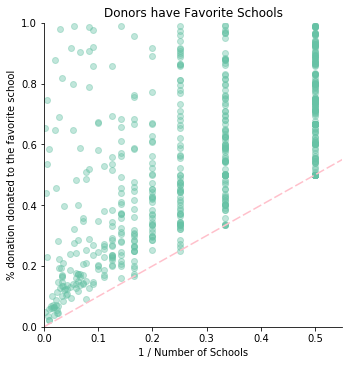

In [4]:
sns.set_palette("Set2")
chartData['1/NumSchool'] = 1/chartData['School ID_count']
chartData = chartData.sample(1000)
#sns.lmplot(data = chartData, y= 'schoolConcentration', x= '1/NumSchool', hue = 'School Bias',fit_reg=False, scatter_kws={'alpha':0.4})
sns.lmplot(data = chartData, y= 'schoolConcentration', x= '1/NumSchool', fit_reg=False, scatter_kws={'alpha':0.4})
plt.ylabel("% donation donated to the favorite school") 
plt.xlabel("1 / Number of Schools")
plt.title("Donors have Favorite Schools")
plt.ylim(0, 1)
plt.xlim(0, 0.55)
x1, y1 = [0, 1], [0, 1]
plt.plot(x1, y1, dashes=[6, 2], color = "pink")
plt.plot()

### Some donors donate to the same teacher despite the teacher moved to a different school

#### There are about 4% of donors exhibit preferences towards a teacher
One explanation for this phenomenon is that the donors could be the friends & family of the teachers.    

For the majority of the donors, if they have donated to two different schools, they would likely to have donated to two different teachers. There are about 4% of the donors with the school count lower than the teacher count.  These could signify prefreference to a specific teacher.

False    0.9594
True     0.0406
Name: Teacher Bias, dtype: float64


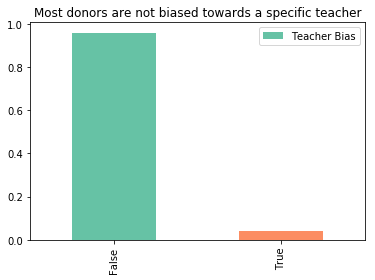

In [5]:
chartData = donorSummary.loc[donorSummary['num_proj']>1]
chartData['Teacher Bias'] = (chartData['School ID_count']) > chartData['Teacher ID_count']
Breakdown = chartData['Teacher Bias'].value_counts()/len(chartData)
Breakdown.plot(kind='bar', stacked=True, legend = True)
plt.title('Most donors are not biased towards a specific teacher')
print(Breakdown)

The chart below shows that for the majority of the donors, the percentage of donation going to their favorite school is higher than the percentage of donations going to the teacher that received their highest amount of donations. The dots on the upper left are the donors, whose donation to their favorite teacher exceeds the donation they have donated to their favorite schools.  

[]

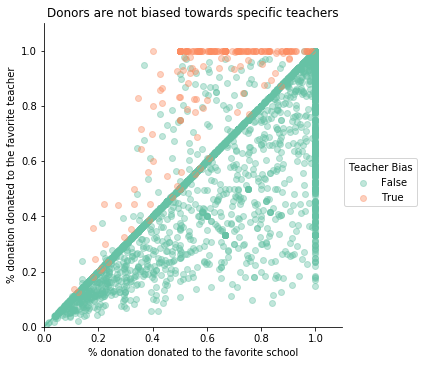

In [6]:
chartData = donorSummary.loc[donorSummary['num_proj']>1]
chartData['Teacher Bias'] = (chartData['School ID_count']) > chartData['Teacher ID_count']
chartData = chartData.sample(5000)
sns.lmplot(data = chartData, x= 'schoolConcentration', y= 'TeacherConcentration', hue = 'Teacher Bias', fit_reg=False, scatter_kws={'alpha':0.4})
plt.xlabel("% donation donated to the favorite school") 
plt.ylabel("% donation donated to the favorite teacher")
plt.title("Donors are not biased towards specific teachers")
plt.ylim(0, 1.1)
plt.xlim(0, 1.1)
x1, y1 = [0, 1], [0, 1]
plt.plot(x1, y1)
plt.plot()

### Donors donate locally

Most of the donors donate to local schools.  The distances are calculated based on the Donor City and School City.  
* Approximately 30% of the donors donate to their own city.  (Donor City = School City)
* Approximately 53% of the donors donate to schools under 20 miles away from home. 
* The median distance between the Donor City and the School City is 16 miles.

The median donation distance is:  15.866542872706095


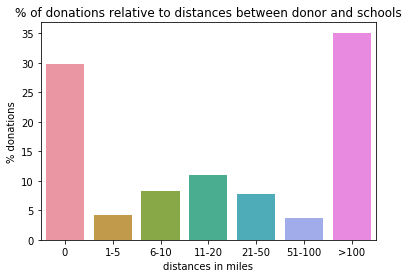

In [7]:
no_mismatch = dist.loc[dist['no_mismatch'] == 1]
chart = pd.DataFrame(no_mismatch['dist_cut'].value_counts()/len(dist)*100).reset_index(drop = False)
plot = sns.barplot(x = 'index', y = 'dist_cut', data = chart)
plot.set_title("% of donations relative to distances between donor and schools")
plot.set_ylabel('% donations')
plot.set_xlabel('distances in miles')

print("The median donation distance is: ", no_mismatch['dist'].median())

### Donors exhibit  preferences toward the different project categories

K-means clustering was used to group the donors into 5 groups, and the following topics are the main interests in each of the groups: 
* Literacy only
* Math, Science, and Applied Science
* Music & Art, Visual Arts
* Literacy, Math, and Science
* Applied Learning, Sports, and Special Needs


In [8]:
# Run K-means model on donor FeatureMatrix 
from sklearn import cluster
k_means = cluster.KMeans(n_clusters=5)

# Group using project categories
colsInclude = list(donorFeatureMatrix.loc[:,'ProjCat_Applied Learning': 'ProjCat_Warmth, Care & Hunger'].columns)
result = k_means.fit(donorFeatureMatrix[colsInclude])

# Get the k-means grouping label
clusterLabel = result.labels_

In [9]:
cluster = pd.DataFrame(clusterLabel)
cluster[0].value_counts()/len(cluster)

1    0.370045
0    0.196474
4    0.195740
3    0.141486
2    0.096256
Name: 0, dtype: float64

In [10]:
def plot_cluster_traits(donorFeatureMatrix, col_category, clusterLabel):
    '''
    col_category are the filters for the column names in the donorFeatureMatrix
    values could be: 
    'Project Type', 'School Metro Type', 'Project Grade Level Category',
    'Project Resource Category', 'lunchAid', 'ProjCat', 'Dist', 'Percentile'
    
    clusterLabel is labels from the output of k-means
    '''
    
    # get columns to chart
    chart = donorFeatureMatrix.filter(regex='^'+col_category, axis=1).copy()
    chart['label'] = clusterLabel
    
    # for each column, get mean of each cluster
    chart = chart.groupby(['label']).mean().reset_index()
    chart_melt = pd.melt(chart, id_vars = ['label'], value_vars = chart.columns[1:], var_name='category', value_name = 'mean')
    chart_melt['color'] = np.where(chart_melt['mean']<0, 'orange', 'pink')
    chart_melt = chart_melt.sort_values(by = ['label', 'category']).reset_index(drop = True)
    
    # delete the col_category from column names for the chart
    chart_melt['category'] = chart_melt['category'].str.replace(col_category+'_','')
    
    # plot chart using Seaborn
    if chart_melt['category'].nunique()>8:
        g = sns.FacetGrid(chart_melt, row = 'label', size=1.5, aspect=8)  # size: height, # aspect * size gives the width
        g.map(sns.barplot, 'category', 'mean', palette="Set1")
        g.set_xticklabels(rotation=90)
        g.fig.subplots_adjust(top=0.9)
        g.fig.suptitle('Cluster Preferences- ' + col_category)
    else:
        g = sns.FacetGrid(chart_melt, row = 'label', size=1.5, aspect=4)
        g.map(sns.barplot, 'category', 'mean', palette="Set2")
        g.fig.subplots_adjust(top=0.9)
        g.fig.suptitle('Cluster Preferences- ' + col_category)
    return g

##### Preferences for Project Categories (adjusted by mean)

C:\Users\kikimeow\Anaconda3\envs\tf\lib\site-packages\seaborn\axisgrid.py:703: UserWarning:

Using the barplot function without specifying `order` is likely to produce an incorrect plot.



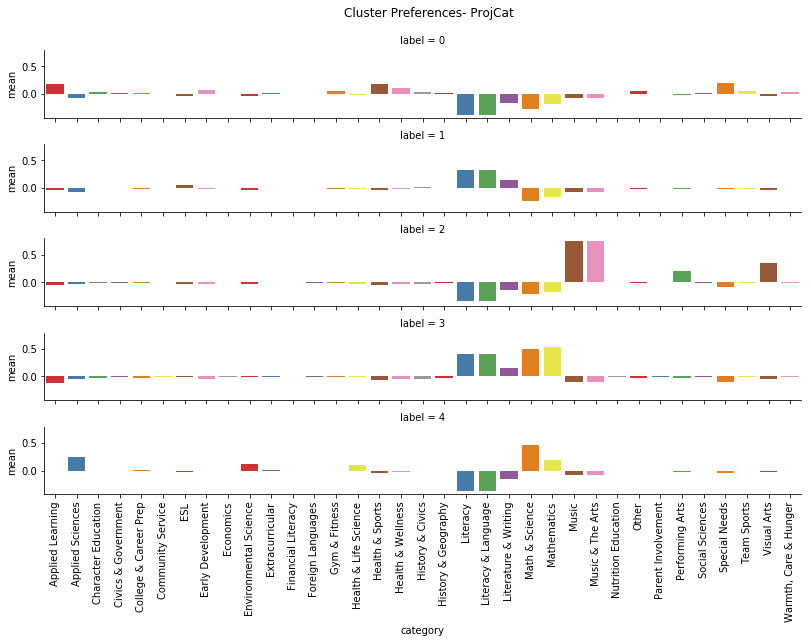

In [11]:
plot_cluster_traits(donorFeatureMatrix, 'ProjCat', clusterLabel)

### <a id='3'>3. Building the Recommender</a>

### A. Set-Up Validation Framework

Use data prior to 2018 (2013-2017) to generate the Donor Features Matrix. Validate model recommendations against the donations occuring in the month of January 2018. The Donor Features Matrix was generated with the (2013-2017) timeframe in Part 1 of the notebook.  

#### Filter for donors who satisfies the following conditions:
1. Donated both in January of 2018 and prior to 2018

In [12]:
donorID_2018 = donations[(donations['Donation_Received_Year'] == 2018) & (donations['Donation_Received_Month'] == 1)]['Donor ID'].unique()
donorID_prior_2018 = donations[donations['Donation_Received_Year'] < 2018]['Donor ID'].unique()
test_ID = list(set(donorID_2018).intersection(donorID_prior_2018))
print("# of IDs matching the criterias:", len(test_ID))

# of IDs matching the criterias: 31362


#### Filter donations into groups: prior to 2018, and Jan 2018

In [13]:
donations_prior = donations[(donations['Donation_Received_Year'] < 2018) & (donations['Donor ID'].isin(test_ID))]
donations_2018 = donations[(donations['Donation_Received_Year'] == 2018) & (donations['Donation_Received_Month'] == 1) & (donations['Donor ID'].isin(test_ID))]
print('donations_prior:', donations_prior.shape)
print('donations_Jan 2018:', donations_2018.shape)

donations_prior: (715574, 10)
donations_Jan 2018: (64617, 10)


#### Filter donor feature matrix

In [14]:
donorFeatureMatrixNoAdj = donorFeatureMatrixNoAdj.loc[donorFeatureMatrixNoAdj.index.isin(test_ID)]
donorFeatureMatrix = donorFeatureMatrix.loc[donorFeatureMatrix.index.isin(test_ID)]
print('Donor Matrix Shape:', donorFeatureMatrix.shape)

Donor Matrix Shape: (31362, 96)


#### Establish the Initial Project Universe
1. Projects that have not been fully funded as of 1/1/2018
2. Project Expiration Date after 1/1/2018
3. Projects posted before 1/31/2018

In [15]:
projectsID = set(projects[(projects['Project Fully Funded Date'] >= '1/1/2018') & (projects['Project Expiration Date'] >= '1/1/2018') & (projects['Project Posted Date'] <= '1/31/2018')]['Project ID'])
print("# of Project IDs matching the criterias:", len(projectsID))

# of Project IDs matching the criterias: 45047


#### Ensure all the projects that the donors donated to are in the Project Features Matrix

In [16]:
projects_2018 = list(donations[(donations['Donation_Received_Year'] == 2018) & (donations['Donation_Received_Month'] == 1)]['Project ID'].unique())
print("# of projects that people donated to in Jan 2018:", len(projects_2018))

projectsID = set(projects_2018).union(set(projectsID))
print("# of projects that people could donate to in Jan 2018:", len(projectsID))

# of projects that people donated to in Jan 2018: 32716
# of projects that people could donate to in Jan 2018: 47816


#### Create the Project Features Matrix

In [17]:
projectFeatures = projFeatures.loc[projFeatures['Project ID'].isin(projectsID)]
projectFeatures = projectFeatures.merge(projects.filter(items = ['Project ID', 'School ID', 'Teacher ID']), left_on = 'Project ID', right_on = 'Project ID', how = 'left')
projectFeatures = projectFeatures.merge(schools.filter(items = ['School ID', 'School_Lon', 'School_Lat', 'School City', 'School State']), left_on = 'School ID', right_on = 'School ID', how = 'left')
projectFeatures = projectFeatures.drop_duplicates(subset=['Project ID'], keep='first')
projectFeatures['CityState'] = projectFeatures['School City'].map(str)+', '+projectFeatures['School State']
print("Number of projects to choose from:", len(projectFeatures))

Number of projects to choose from: 47816


### B. Define Recommendation Function

In [18]:
def merge_data(ID, donations, donors = donors, projects = projects, schools = schools):
    ''' 
    Filter data based on a list of Donor ID.  Merge all data together into one dataframe.  
    Arguments: list of 'Donor ID'
    Returns: dataframe 
    '''
    
    # To ensure ID parameter works for both a list and a string
    if isinstance(ID, list):
        temp = donations[donations['Donor ID'].isin(ID)].reset_index(drop = True)
    else:
        temp = donations[donations['Donor ID'] == ID].reset_index(drop = True)
    
    temp = temp.merge(donors, on = 'Donor ID', how='left')
    temp = temp.merge(projects, on = 'Project ID', how = 'left')
    temp = temp.merge(schools, on = 'School ID', how = 'left')
    
    return temp

In [19]:
def get_proj_universe(ID,
                      donorDonations_all = None,
                      donations_prior = donations_prior, 
                      donors = donors, 
                      projects = projects, 
                      schools = schools):
    
    #print("Donor ID:", ID)
    
    ####
    # Merge donations data filtered by ID with donors, projects, schools
    ####
    
    if donorDonations_all is None:
        donorDonations = merge_data(ID, donations_prior)
        
    else:
        donorDonations = donorDonations_all.loc[donorDonations_all['Donor ID'] == ID]
    
    donorDonations = donorDonations.reset_index(drop = True)
    
    ####
    #  Get Previous School ID, Teacher ID, School Location (City/State), Donor's Location
    ####
    
    # previous locations of donations
    byLocation = donorDonations.groupby(['School City', 'School State'])['Donation Amount'].sum().sort_values(ascending = False)
    locMap = donorDonations.drop_duplicates(subset = ['School City', 'School State']).set_index((['School City', 'School State']))
    byLocation = byLocation.reset_index()
    
    # calculate the rank of city according to amount of donation received
    byLocation['byLocation rank']= byLocation['Donation Amount'].rank(ascending = False) # rank from largest to smallest
    
    # calculate the Frequent location bonus scoring scale
    byLocation['byLocation scale'] = 1/(byLocation['byLocation rank']/len(byLocation))/100
    
    # add longitude and latitude data for reference later
    byLocation = byLocation.set_index(['School City', 'School State'])
    byLocation = byLocation.merge(locMap.filter(items = ['School_Lon', 'School_Lat']), left_index = True, right_index = True, how = 'left')
    byLocation = byLocation.reset_index()
    byLocation['CityState'] = byLocation['School City'].map(str)+', '+byLocation['School State']
    
    # donor's location
    donorLocation = donors.loc[donors['Donor ID'] == ID, ['Donor City', 'Donor State', 'Donor_Lat', 'Donor_Lon']].reset_index(drop = True)
    donorLocation['CityState'] = donorLocation['Donor City'].map(str)+', '+donorLocation['Donor State']
    
    # get the ID masks for filtering donor donations
    schoolIDs = donorDonations['School ID'].unique()
    teacherIDs = donorDonations['Teacher ID'].unique()
    locationIDs = byLocation['CityState'].unique()
    homeIDs = donorLocation['CityState'].unique() 
    
    idFilters = {'schoolIDs':schoolIDs, 
                 'teacherIDs':teacherIDs,
                 'locationIDs':locationIDs,
                 'homeIDs':homeIDs}
    
    
    ####
    # Filter projectFeatures for Schools, Teachers, Locations that the donor has ever donated to
    ####
    
    projSchool = list(projectFeatures[projectFeatures['School ID'].isin(schoolIDs)]['Project ID'])
    projTeacher = list(projectFeatures[projectFeatures['Teacher ID'].isin(teacherIDs)]['Project ID'])
    projLocation = list(projectFeatures[projectFeatures['CityState'].isin(locationIDs)]['Project ID'])
    projHomeLoc = list(projectFeatures[projectFeatures['CityState'].isin(homeIDs)]['Project ID'])
    projAll = set(projSchool).union(set(projTeacher)).union(set(projLocation)).union(set(projHomeLoc))
    
    projFilters = {'projSchool':projSchool, 
                 'projTeacher':projTeacher,
                 'projLocation':projLocation,
                 'projHomeLoc':projHomeLoc,
                  'projAll': projAll}
    
    ####
    #  Filter the project Features based on 'Project IDs'
    ####
    
    projUniverse = projectFeatures.loc[projectFeatures['Project ID'].isin(projAll)]
    projUniverse = projUniverse.reset_index(drop = True)
    #print('Number of potential projects:', len(projUniverse))
    
    return projUniverse, donorDonations, byLocation, idFilters, projFilters, donorLocation

def calculate_score(ID, projUniverse, byLocation, projFilters, donorFeatureMatrix, projectFeatures):

    ####
    # Generate Donor Feature Matrix, Calculate Score, Rank Recommendations
    ####
    
    #### Get Donor FeatureMatrix #### 
        
    #donorFeatureMatrix = donorFeatureMatrix.set_index('Donor ID')  # if donorFeatureMatrix did not have index set
    y = donorFeatureMatrix.loc[ID, 'Project Type_Professional Development':'ProjCat_Warmth, Care & Hunger'] 
    y = y.values.reshape(len(y), 1) 

    #### Calculate Similarity Score
    score = np.dot(projUniverse.loc[:, 'Project Type_Professional Development':'ProjCat_Warmth, Care & Hunger'], y)
        
    #### Add more Scoring Attributes
        
    # score from dot product of similarity
    projUniverse['Score_interest'] = score
        
    # Flag as 1 if the project matches the conditions
    projUniverse['Score_School'] = projUniverse['Project ID'].isin(projFilters['projSchool'])
    projUniverse['Score_Teacher'] = projUniverse['Project ID'].isin(projFilters['projTeacher'])
    projUniverse['Score_homeLoc'] = projUniverse['Project ID'].isin(projFilters['projHomeLoc'])
    projUniverse['Score_priorLoc'] = projUniverse['Project ID'].isin(projFilters['projLocation'])
        
    # merge the scoring matrix
    projUniverse = projUniverse.merge(byLocation.filter(items = ['byLocation rank', 'byLocation scale', 'CityState']), on = 'CityState', how = 'left')

    #### Rank Recommendations #### 
    cols = ['Score_interest', 'Score_School', 'Score_Teacher','Score_homeLoc', 'Score_priorLoc']
    projUniverse['Score_Total_Unadjusted'] = projUniverse.loc[:, cols].sum(axis = 1)
        
    projUniverse['location_Premium'] = projUniverse['Score_Total_Unadjusted']*projUniverse['byLocation scale']

    cols = ['Score_interest', 'Score_School', 'Score_Teacher','Score_homeLoc', 'Score_priorLoc', 'location_Premium']
    projUniverse['Score_Total'] = projUniverse.loc[:, cols].sum(axis = 1)
        
    projUniverse['Rank'] = projUniverse['Score_Total'].rank(ascending = False)
    projUniverse = projUniverse.sort_values(by = 'Rank' )
    projUniverse = projUniverse.set_index('Project ID')
    
    return projUniverse

def get_recommender_response(ID, projUniverse, donations_2018, donorDonations, idFilters, donorLocation):
    
    # Length of potential project selections (Project Universe)
    lenUniv = len(projUniverse) 
    
    # Donor City
    donorCity = donorLocation['CityState'].values

    #### Get the actual project (target project ID) that the donor donated to
    targetProjectIDs = donations_2018[donations_2018['Donor ID'] == ID]['Project ID']
    proj = targetProjectIDs.values[0]  # get default

    ####
    # Save scores breakdown for the top recommended project
    ####
    
    if len(projUniverse)> 0:
        topProj = projUniverse.index[0]
        score_interest_top = projUniverse.loc[topProj]['Score_interest']
        score_school_top = projUniverse.loc[topProj]['Score_School']
        score_teacher_top = projUniverse.loc[topProj]['Score_Teacher']
        score_homeLoc_top = projUniverse.loc[topProj]['Score_homeLoc']
        score_priorLoc_top = projUniverse.loc[topProj]['Score_priorLoc']
        score_locBonus_top = projUniverse.loc[topProj]['location_Premium']
        score_scoreTotal_top =  projUniverse.loc[topProj]['Score_Total']
        Top_Project_Score = {'interest':score_interest_top, 'school':score_school_top,
                             'teacher':  score_teacher_top, 'homeLoc': score_homeLoc_top, 
                             'priorLoc': score_priorLoc_top, 'locBonus': score_locBonus_top,
                             'total':score_scoreTotal_top}
   
    ####
    # Identify the actual project (target project) that the donor donated and find the recommender ranking of the target project
    ####
 
    # loop through multiple projects for donors that donated to multiple projects in the testing timeframe
        for i in range(len(targetProjectIDs)):
            proj = targetProjectIDs.values[i]
        
        ### Get ranking of the project that the donor donated to
            try:
                ranking = projUniverse.loc[proj]['Rank']
                score_interest_target = projUniverse.loc[proj]['Score_interest']
                score_school_target = projUniverse.loc[proj]['Score_School']
                score_teacher_target = projUniverse.loc[proj]['Score_Teacher']
                score_homeLoc_target = projUniverse.loc[proj]['Score_homeLoc']
                score_priorLoc_target = projUniverse.loc[proj]['Score_priorLoc']
                score_locBonus_target = projUniverse.loc[proj]['location_Premium']
                score_scoreTotal_target =  projUniverse.loc[proj]['Score_Total']
                Target_Project_Score = {'interest':score_interest_target, 'school':score_school_target, 
                                        'teacher':  score_teacher_target, 'homeLoc': score_homeLoc_target, 
                                        'priorLoc': score_priorLoc_target, 'locBonus': score_locBonus_target,
                                        'total': score_scoreTotal_target}
                # if project matches, skip the rest of the search
                
                break  
            except:
                ranking = np.nan 
                score_interest_target = np.nan
                score_school_target = np.nan
                score_teacher_target = np.nan
                score_homeLoc_target = np.nan
                score_priorLoc_target = np.nan
                score_locBonus_target = np.nan
                score_scoreTotal_target = np.nan
                Target_Project_Score = {}
    else:
        topProj = np.nan
        score_interest_target = np.nan
        score_school_target = np.nan
        score_teacher_target = np.nan
        score_homeLoc_target = np.nan
        score_priorLoc_target = np.nan
        score_locBonus_target = np.nan
        score_scoreTotal_target = np.nan
        Top_Project_Score = {}
        Target_Project_Score = {}
        ranking = np.nan 
        score_interest_target = np.nan
        score_school_target = np.nan
        score_teacher_target = np.nan
        score_homeLoc_target = np.nan
        score_priorLoc_target = np.nan
        score_locBonus_target = np.nan
        score_scoreTotal_target = np.nan
        
    ####
    # Return dictionary 
    ####
    response = {'Donor_ID': ID, 
                'Ranking': ranking, 
                'Donor_Project_ID': proj, 
                'Filter_Size': lenUniv, 
                'Universe': projUniverse, 
                'Donor_Donations': donorDonations,
                'Prior_Location_Count': len(idFilters['locationIDs']), 
                'Prior_School_Count': len(idFilters['schoolIDs']),
                'Prior_Teacher_Count': len(idFilters['teacherIDs']), 
                'Donor_City': donorCity,
                'Target_Project_Score': Target_Project_Score,
                'Top_Project_Score':  Top_Project_Score,
                'Top_Project': topProj
               }
    
    return response

def recommender(ID,
                donorDonations_all = None,
                donations_prior = donations_prior, 
                donations_2018 = donations_2018,
                donors = donors, 
                projects = projects, 
                schools = schools, 
                donorFeatureMatrix = donorFeatureMatrix,
                projectFeatures = projectFeatures):
    
    projUniverse, donorDonations, byLocation, idFilters, projFilters, donorLocation = get_proj_universe(ID, donorDonations_all, donations_prior, donors, projects, schools) 
    
    if (len(projUniverse))>0:
        projUniverse = calculate_score(ID, projUniverse,  byLocation, projFilters, donorFeatureMatrix, projectFeatures)
    
    response = get_recommender_response(ID,projUniverse, donations_2018, donorDonations, idFilters, donorLocation)
    
    return response


In [20]:
def recommenderAnalysis(response):
    '''
    Print some information from the response
    '''
    print("The project chosen by the donor is ranked:", response['Ranking'])
    print("Total projects in the Project Universe is:", response['Filter_Size'])
    print("Number of project count prior to 2018:", len(response['Donor_Donations']))
    print("Number of teacher count prior to 2018:", response['Prior_Teacher_Count'])
    print("Number of school count prior to 2018:", response['Prior_School_Count'])
    print("Number of locations that the donor donated to prior to 2018:", response['Prior_Location_Count'])
    print("Donor City:", response['Donor_City'])
    print('Recommended Project:', response['Top_Project'])
    print('Top Project Score:', response['Top_Project_Score'])
    print("The donor donated to Project ID:", response['Donor_Project_ID'])
    print('Target Project Score:', response['Target_Project_Score'])
    
    return None

def top5Recommendations(response,
                       projects = projects,
                       schools = schools):   
    '''
    return top 5 recommendations from recommender
    '''
    
    cols = ['Score_interest', 'Score_School', 'Score_Teacher', 'Score_homeLoc','Score_priorLoc', 'byLocation rank', 'byLocation scale','Score_Total_Unadjusted', 'location_Premium', 'Score_Total', 'Rank']
    responseScores = response['Universe'][cols][0:5]
    picks = response['Universe'].index[0:5]
    recommendedProj = projects.loc[projects['Project ID'].isin(picks)]
    TopRecommendations = recommendedProj.merge(schools, left_on= 'School ID', right_on = 'School ID', how = 'left')
    TopRecommendations = TopRecommendations.merge(responseScores, left_on= 'Project ID', right_index = True, how = 'left')
    TopRecommendations.sort_values(by = 'Rank', ascending = True)
    
    return TopRecommendations


def targetProject(response, schools = schools, projects = projects):
    '''
    return information regarding the project that the donor donated to
    '''
    i = response['Ranking'].astype('int')
    cols = ['Score_interest', 'Score_School', 'Score_Teacher', 'Score_homeLoc','Score_priorLoc', 'byLocation rank', 'byLocation scale','Score_Total_Unadjusted', 'location_Premium', 'Score_Total', 'Rank']
    responseScores = response['Universe'][cols][i-1: i]
    picks = response['Donor_Project_ID']
    correctProj = projects.loc[projects['Project ID'] == picks]
    correctProj = correctProj.merge(schools, left_on= 'School ID', right_on = 'School ID', how = 'left')
    correctProj = correctProj.merge(responseScores, left_on= 'Project ID', right_index = True, how = 'left')
    correctProj 
    
    return correctProj

def mostRecentDonations(response):
    '''
    return donor's most recent donation
    '''
    
    return response['Donor_Donations'].sort_values(by = 'Donation Received Date', ascending = False).head()

def donor_profile(response):
    '''
    return profile of donor from donor summary and donor interest
    '''
    
    df = donorSummary.loc[donorSummary['Donor ID'] == response['Donor_ID']]
    df = df.merge(donorInterest, left_on = "Donor ID", right_index = True, how = 'left')
    
    return df



### <a id='4'>4. An example of the recommender output</a>

The recommender works extremely well when donor follows prior behaviors, such as donating to the same city, same school, or to the same teacher.  

In [21]:
response = recommender('979307a224e6f15f9af7570a0829faf9')

In [22]:
recommenderAnalysis(response)

The project chosen by the donor is ranked: 4.0
Total projects in the Project Universe is: 5824
Number of project count prior to 2018: 95
Number of teacher count prior to 2018: 82
Number of school count prior to 2018: 81
Number of locations that the donor donated to prior to 2018: 58
Donor City: ['Elmhurst, New York']
Recommended Project: e259bc69946d180f399c8aadea6acf03
Top Project Score: {'school': True, 'homeLoc': False, 'interest': 0.8225762767710585, 'locBonus': 2.2170942405272136, 'teacher': True, 'total': 6.039670517298272, 'priorLoc': True}
The donor donated to Project ID: 5b094f7c19c868c6f8ecc33b761e4b21
Target Project Score: {'school': True, 'homeLoc': False, 'interest': 0.3635705575011058, 'locBonus': 1.9508709233506414, 'teacher': True, 'total': 5.314441480851747, 'priorLoc': True}


The recommender underperforms when the donor has a strong preference towards a location, but did not choose to donate in that location.  <br>
Seeing this result, the Frequent Location Bonus could be modified to measure the strength of preference to a location, rather than just base on ranking of location.  

In [23]:
response = recommender('9deb2badf754468194f0ca69762a243d')

In [24]:
recommenderAnalysis(response)

The project chosen by the donor is ranked: 3307.5
Total projects in the Project Universe is: 12652
Number of project count prior to 2018: 451
Number of teacher count prior to 2018: 239
Number of school count prior to 2018: 212
Number of locations that the donor donated to prior to 2018: 177
Donor City: ['Pompano Beach, Florida']
Recommended Project: 1f61c84d8e43bc842fa30ca267855c2a
Top Project Score: {'school': True, 'homeLoc': False, 'interest': 0.840678351140776, 'locBonus': 6.798000681519174, 'teacher': True, 'total': 10.63867903265995, 'priorLoc': True}
The donor donated to Project ID: 52c56928107598e1bb7c500e92d058f0
Target Project Score: {'school': False, 'homeLoc': False, 'interest': 0.4805492958707057, 'locBonus': 0.07082627712678781, 'teacher': False, 'total': 1.5513755729974934, 'priorLoc': True}


#### Top 5 recommendations from Recommender

In [25]:
top5Recommendations(response)

,Project ID,School ID,Teacher ID,Teacher Project Posted Sequence,Project Type,Project Subject Category Tree,Project Subject Subcategory Tree,Project Grade Level Category,Project Resource Category,Project Cost,...,Score_School,Score_Teacher,Score_homeLoc,Score_priorLoc,byLocation rank,byLocation scale,Score_Total_Unadjusted,location_Premium,Score_Total,Rank
0,d447f193ee34d5318856a0718b739221,94b4c73e5a477f14551375df249bee90,df40c0be9e44bfa1bc6f005e9c46bcaa,161.0,Professional Development,"Applied Learning, Music & The Arts","Other, Visual Arts",Grades 3-5,Instructional Technology,392.329987,...,True,True,False,True,1.0,1.77,3.718483,6.581716,10.300199,2.0
1,afd27a9f0d14de227ce56e198ae9961e,94b4c73e5a477f14551375df249bee90,df40c0be9e44bfa1bc6f005e9c46bcaa,164.0,Teacher-Led,"Applied Learning, Music & The Arts","Character Education, Visual Arts",Grades 3-5,Instructional Technology,388.470001,...,True,True,False,True,1.0,1.77,3.691455,6.533875,10.225329,4.0
2,6f4cbb45ebb4a18be013003ca6fc7b07,94b4c73e5a477f14551375df249bee90,df40c0be9e44bfa1bc6f005e9c46bcaa,166.0,Teacher-Led,Literacy & Language,"ESL, Literature & Writing",Grades 3-5,Educational Kits & Games,467.850006,...,True,True,False,True,1.0,1.77,3.619047,6.405712,10.024759,5.0
3,1f61c84d8e43bc842fa30ca267855c2a,94b4c73e5a477f14551375df249bee90,df40c0be9e44bfa1bc6f005e9c46bcaa,167.0,Teacher-Led,"Literacy & Language, Music & The Arts","Literacy, Visual Arts",Grades 3-5,Art Supplies,213.279999,...,True,True,False,True,1.0,1.77,3.840678,6.798001,10.638679,1.0
4,e99bef61782affa0ea9e7fe670bd54e6,94b4c73e5a477f14551375df249bee90,df40c0be9e44bfa1bc6f005e9c46bcaa,168.0,Teacher-Led,"Applied Learning, Music & The Arts","Early Development, Visual Arts",Grades PreK-2,Art Supplies,307.660004,...,True,True,False,True,1.0,1.77,3.707504,6.562282,10.269786,3.0


#### Most recent projects that donor donated to

In [26]:
mostRecentDonations(response)

,Project ID,Donation ID,Donor ID,Donation Included Optional Donation,Donation Amount,Donor Cart Sequence,Donation Received Date,Donation_Received_Year,Donation_Received_Month,Donation_Received_Day,...,School Metro Type,School Percentage Free Lunch,School State,School Zip,School City,School County,School District,mapIndex_y,School_Lon,School_Lat
282,a75ce158450dced6744d5f5557418a66,10735913ccd3d6f9eb46fd4e80b04bad,9deb2badf754468194f0ca69762a243d,True,5.0,370,2017-12-31 17:21:11,2017,12,31,...,suburban,63.0,Florida,33067,Coral Springs,Broward,Broward Co Public Schools,"Coral Springs, Florida, USA",-80.270604,26.271192
268,9d0705e02b6dda69db310f384a196bd2,27aeb75ee9e7a01c53988729b065425b,9deb2badf754468194f0ca69762a243d,True,5.0,369,2017-12-31 17:19:25,2017,12,31,...,suburban,63.0,Florida,33067,Coral Springs,Broward,Broward Co Public Schools,"Coral Springs, Florida, USA",-80.270604,26.271192
31,15784745c4258bf42eb5abcb1813ddd9,4c43da9dbaee4eef8315fc126c118e8f,9deb2badf754468194f0ca69762a243d,True,2.0,368,2017-12-30 14:11:34,2017,12,30,...,suburban,67.0,Georgia,31407,Prt Wentworth,Chatham,Savannah-Chatham Co Sch Dist,"Prt Wentworth, Georgia, USA",-81.163168,32.149092
308,ba6ffa6289df53a8671a775bc7f3285a,efc71988d5e5256665f2aa0b88039238,9deb2badf754468194f0ca69762a243d,True,1.0,367,2017-03-12 12:52:48,2017,3,12,...,urban,76.0,New York,11214,New York City,Kings (Brooklyn),New York City Dept Of Ed,"New York City, New York, USA",-74.002600,40.604233
334,c7888727622f0b5d793b64ed330e76fe,54543e9ad2f92800d35a69676281dfe8,9deb2badf754468194f0ca69762a243d,True,10.0,366,2017-01-22 14:07:41,2017,1,22,...,suburban,63.0,Florida,33067,Coral Springs,Broward,Broward Co Public Schools,"Coral Springs, Florida, USA",-80.270604,26.271192


#### Donor Profile

In [27]:
donor_profile(response)

,Donor ID,num_proj,num_donation,num_cart,donation_median,donation_mean,donation_sum,donation_std,Teacher ID_count,School ID_count,...,ProjCat_Visual Arts,"ProjCat_Warmth, Care & Hunger",Dist_0,Dist_1-5,Dist_6-10,Dist_11-20,Dist_21-50,Dist_51-100,Dist_>100,dist
Donor ID,,,,,,,,,,,,,,,,,,,,,
9deb2badf754468194f0ca69762a243d,9deb2badf754468194f0ca69762a243d,370,349,451,1.0,1.520732,685.849976,2.02952,239,212,...,0.169133,0.0,0.0,0.0,0.288693,0.0,0.013122,0.001458,0.696727,889.140976


### <a id='5'>5. Recommender Performance</a>

In [28]:
def accuracy(test_ID, 
             numSample, 
             donations_prior = donations_prior,
             donations_2018 = donations_2018, 
             donors = donors, 
             projects = projects, 
             schools = schools, 
             donorFeatureMatrix = donorFeatureMatrix, 
             projectFeatures = projectFeatures):
    
    donorDonations_all = merge_data(test_ID, donations_prior)
    recommendations = pd.DataFrame(columns=['Donor ID', 'Donor Project ID','Ranking', 
                                            'Filter Size', 'Prior Donation Count', 'Prior Location Count'])
    IDs = pd.Series(test_ID).sample(n= numSample, random_state = 212)
    recommendations['Donor ID'] = IDs
    recommendations = recommendations.set_index('Donor ID', drop = False)
    i = 1
    
    for ID in IDs:
        #print('Processing #:', i)
        response = recommender(ID, donorDonations_all)
        recommendations.loc[ID, 'Ranking'] = response['Ranking']
        recommendations.loc[ID, 'Donor Project ID'] = response['Donor_Project_ID']
        recommendations.loc[ID, 'Filter Size'] = response['Filter_Size']
        recommendations.loc[ID, 'Prior Donation Count'] = len(response['Donor_Donations'])
        recommendations.loc[ID, 'Prior Location Count'] = response['Prior_Location_Count']
        
        i+=1
    return recommendations

In [29]:
recommendations = accuracy(test_ID, 5000)

In [30]:
recommendations.head()

,Donor ID,Donor Project ID,Ranking,Filter Size,Prior Donation Count,Prior Location Count
Donor ID,,,,,,
64be7ffabdd4b047aebe0f990e8a415a,64be7ffabdd4b047aebe0f990e8a415a,18596642dd57e77f8a9daf050368c5a1,1.5,160,4,1
757f10f202af3bd7f160abf94aa9d1aa,757f10f202af3bd7f160abf94aa9d1aa,4f1f04d0607a1e8c3da4beae11f4df2a,9,64,1,1
745e3016759447e6722cbb9133987eeb,745e3016759447e6722cbb9133987eeb,5eff55b00cd4f53040d7ce6fc482e0d3,NaN,2734,7,3
afc36e80c10e614e9d5fa5de672ced01,afc36e80c10e614e9d5fa5de672ced01,2aac32a2c08f71ad958ef75350554708,1,103,10,3
cb2968e03212aeffd9be8517070c04d6,cb2968e03212aeffd9be8517070c04d6,344d0ba3b36c7e32ad97df126cbc7a36,1,190,8,1


In [31]:
#recommendations = pd.read_pickle('recommendations_1000.pkl')

In [32]:
recommendations.to_pickle('recommendations_1000.pkl')

###  Filtering projects using donor's previous donation history based on home city and school cities captured the future donation 81% of the times.

In [33]:
print('% of time the filter captured the correct project:', recommendations['Ranking'].notnull().sum()/len(recommendations))

% of time the filter captured the correct project: 0.8196


### The recommender correctly ranked the #1 project approximately 35% of the times.

% Hit in top 1 Recommendations: 34.239999999999995
% Hit in top 5 Recommendations: 55.459999999999994
% Hit in top 10 Recommendations: 61.279999999999994
% Hit in top 25 Recommendations: 67.67999999999999


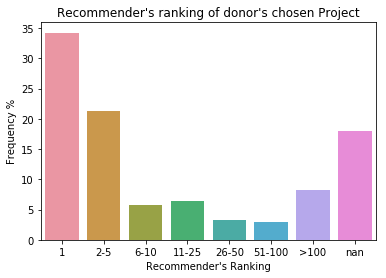

In [34]:
chartData = recommendations.copy()
chartData['Ranking'] = chartData['Ranking'].astype('Float32')
chartData['Ranking Range'] = pd.cut(chartData['Ranking'], bins = [0, 1, 5, 10, 25, 50, 100, 70000], labels = ['1', '2-5', '6-10', '11-25', '26-50', '51-100', '>100'])
chartData['Ranking Range']= chartData['Ranking Range'].astype(str)
chartData = chartData.groupby('Ranking Range').agg('count')
chartData['Frequency'] = chartData['Donor ID']/chartData['Donor ID'].sum()*100
chartData = chartData.reindex(index = ['1', '2-5', '6-10', '11-25', '26-50', '51-100', '>100', 'nan'])

g =sns.barplot(chartData.index, chartData['Frequency'])
g.set(xlabel="Recommender's Ranking", ylabel='Frequency %', title = "Recommender's ranking of donor's chosen Project")

print('% Hit in top 1 Recommendations:', chartData['Frequency'][0:1].sum() )
print('% Hit in top 5 Recommendations:', chartData['Frequency'][0:2].sum() )
print('% Hit in top 10 Recommendations:', chartData['Frequency'][0:3].sum() )
print('% Hit in top 25 Recommendations:', chartData['Frequency'][0:4].sum() )

### <a id='6'>6. Causes of underformance and how to improve the model?</a>

#### We will first look at situations where the recommender fails to include the target project in the Project Universe

In [35]:
recommendations['notInFilter'] = recommendations['Ranking'].isnull()
cols = ['Filter Size', 'Prior Donation Count', 'Prior Location Count', 'notInFilter']
recommendations[cols] = recommendations[cols].astype('float32')
donorSummary = donorSummary.drop(['Donor ID'], axis=1)

#### The recommender filter is mostly location based, therefore when the donor does not have a preference for a geographic location, the recommender underperforms.  

The chart shows that the for the instances where recommender did not include the target project in the filter, the standard deviation of the distances that the donor donates to is very high. 

[]

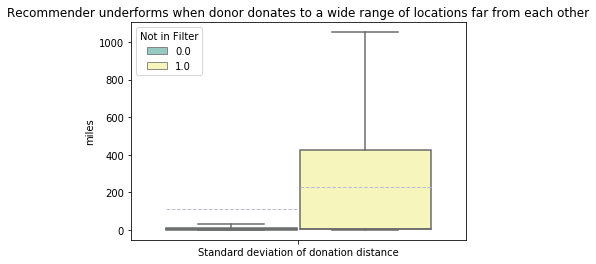

In [36]:
chartData = recommendations.merge(donorSummary[['Dist_std']], left_index = True, right_index = True, how = 'left')
cols = ['Dist_std', 'notInFilter']
chartData = chartData[cols]

chartData.columns = ['Standard deviation of donation distance', 'Not in Filter']
chartData = pd.melt(chartData, id_vars=['Not in Filter'], var_name = 'Category')

sns.set_palette("Set3")
ax = sns.boxplot(x="Category", y="value", hue = 'Not in Filter', data = chartData, showfliers = False, showmeans = True, meanline = True)
ax.set_xticklabels(ax.get_xticklabels(),rotation=0)

plt.title("Recommender underforms when donor donates to a wide range of locations far from each other")
plt.xlabel('')
plt.ylabel('miles')

ax.plot()

#### The recommender filter is less likely to capture the target project when the donor donates to fewer number of locations
In this situation, the universe is probably too small, especially when the donor previously donated to cities with few available projects. 

The recommender can be modified to have a minimal number of potential projects. If the size of the project universe is under the threshold, the search could be expanded by searching the neighboring locations.  

[]

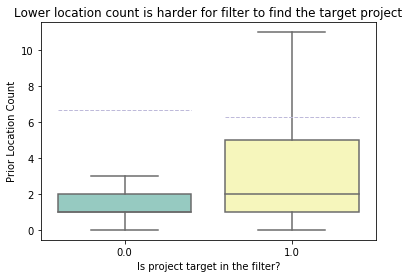

In [37]:
sns.boxplot(x = 'notInFilter', y="Prior Location Count", data=recommendations, showfliers = False, showmeans = True, meanline = True)
plt.title('Lower location count is harder for filter to find the target project')
plt.xlabel('Is project target in the filter?')
ax.plot()

#### The recommender was not able to distinguish donors who have a specific cause in mind
##### Help the Underpreviledged  & Special Needs Students
There is a group of donors whose target project is not in the project universe.  They have showed a stronger preference toward schools with higher percentage of students receiving free lunch, or were more interested in projects relating to Special Needs.  
These segement of donors are the ones with a cause in mind that they would like to achieve.  

The recommender algorithm could be modified to target these donors with projects from underpriveledged schools.  One approach would be to recommend projects from those specific areas when the donor's interest in these areas is above the average donor.  Collaborative filtering would be useful.  Once we segment out these donors, collaborative filtering can be used to recommend projects from the like-minded donors.  

[]

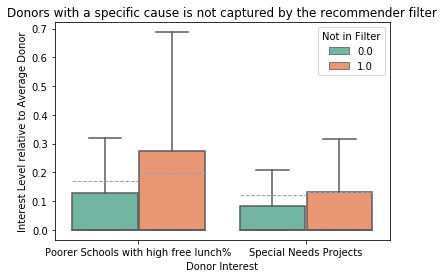

In [38]:
chartData = recommendations.merge(donorInterest[['lunchAid_poor', 'ProjCat_Special Needs']], left_index = True, right_index = True, how = 'left')

cols = ['lunchAid_poor', 'ProjCat_Special Needs', 'notInFilter']
chartData = chartData[cols]
chartData.columns = ['Poorer Schools with high free lunch%', 'Special Needs Projects', 'Not in Filter']
chartData = pd.melt(chartData, id_vars=['Not in Filter'], var_name = 'Category')
sns.set_palette("Set2")


ax = sns.boxplot(x="Category", y="value", hue = 'Not in Filter', data = chartData, 
                 showfliers = False, showmeans = True, meanline = True)
ax.set_xticklabels(ax.get_xticklabels(),rotation=0)

plt.title('Donors with a specific cause is not captured by the recommender filter')
plt.xlabel("Donor Interest")
plt.ylabel('Interest Level relative to Average Donor')
ax.plot()

The interest level measures the donor's interest in the category compared to the average.  Looking at the x-axis, there is a hump around 0.8. The hump in the distribution chart are the donors who have showed a higher level interest in the areas of underpreviledged schools and students with special needs.  <br>

The algorithm can be modified to recommend projects in these areas when the interest level is above average, maybe around the peak of the second bumps.  

[]

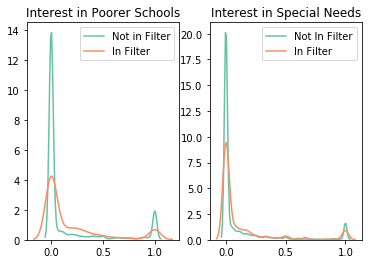

In [39]:
chartData = recommendations.merge(donorInterest[['lunchAid_poor', 'ProjCat_Special Needs']], left_index = True, right_index = True, how = 'left')
cols = ['lunchAid_poor', 'ProjCat_Special Needs', 'notInFilter']
chartData = chartData[cols]
chartData.columns = ['Poorer Schools', 'Special Needs Projects', 'Not in Filter']

plt.subplot(1, 2, 1)

sns.set_palette("Set2")
yesIn = chartData.loc[chartData['Not in Filter'] == 1]
noIn = chartData.loc[chartData['Not in Filter'] != 1]
sns.distplot(noIn[['Poorer Schools']], hist = False, label = 'Not in Filter')
sns.distplot(yesIn[['Poorer Schools']], hist = False, label = 'In Filter')
plt.title('Interest in Poorer Schools')

sns.set_palette("Set2")
plt.subplot(1, 2, 2)
yesIn = chartData.loc[chartData['Not in Filter'] == 1]
noIn = chartData.loc[chartData['Not in Filter'] != 1]
sns.distplot(noIn[['Special Needs Projects']], hist = False, label = 'Not In Filter')
sns.distplot(yesIn[['Special Needs Projects']], hist = False, label = 'In Filter')
plt.title('Interest in Special Needs')
plt.plot()

The recommender indeed under-recommend the Special Needs Projects. 

In [40]:
chartData = recommendations[['notInFilter', 'Donor Project ID']].merge(projFeatures, left_on = 'Donor Project ID', right_on = 'Project ID', how = 'left')

print("% of Special Needs Projects where project is not in Filter: {0:.2f}%".format(chartData.groupby('notInFilter')['ProjCat_Special Needs'].value_counts(normalize = True)[1][1]*100))
print("% of Special Needs Projects where project is in Filter: {0:.2f}%".format(chartData.groupby('notInFilter')['ProjCat_Special Needs'].value_counts(normalize = True)[0][1]*100))
pd.crosstab(chartData['notInFilter'],chartData['ProjCat_Special Needs'], normalize='index')

% of Special Needs Projects where project is not in Filter: 14.08%
% of Special Needs Projects where project is in Filter: 12.64%


ProjCat_Special Needs,0.0,1.0
notInFilter,,
0.0,0.873597,0.126403
1.0,0.859202,0.140798


The same is true for projects from schools where more students receive free lunch, despite the differences are smaller.  

In [41]:
chartData = recommendations[['notInFilter', 'Donor Project ID']].merge(projFeatures, left_on = 'Donor Project ID', right_on = 'Project ID', how = 'left')
print("% of higher free lunch% schools where project is not in filter: {0:.2f}%".format(chartData.groupby('notInFilter')['lunchAid_poor'].value_counts(normalize = True)[1][1]*100))
print("% of higher free lunch% schools where project is in filter: {0:.2f}%".format(chartData.groupby('notInFilter')['lunchAid_poor'].value_counts(normalize = True)[0][1]*100))
pd.crosstab(chartData['notInFilter'],chartData['lunchAid_poor'], normalize='index')

% of higher free lunch% schools where project is not in filter: 18.40%
% of higher free lunch% schools where project is in filter: 16.76%


lunchAid_poor,0,1
notInFilter,,
0.0,0.832357,0.167643
1.0,0.815965,0.184035


### <a id='7'>7. Future Enhancements</a>

The current filtering method limits the search to cities that the donor either live in or have donated to. As discussed in the previous section, the filter underperforms when the donor donated to fewer cities especially in cities with low number of available projects.  To solve this problem, a minimal size of the project universe can be set.  When the number of projects returned by the filter is lower than the threshold, the search can be expanded to to nearby cities within 15 miles radius of the donor's home. 15 miles was the median distance between the school city and donor city of all the donors. 

The current model does not cater towards donors with a specific cause in mind, such as helping the underpriveledged schools and students with special needs.  The model could be modified to screen for special interest by using the features that measures donor's interest against the population mean.  These features are already created in the Donor Features Matrix.  If the donor's interest is around 70% above the average donor, then the recommender should automatically recommend projects associated with these causes.  We can recommend projects that are of interest to the other donors who are also interested in underpreviledged schools and kids with special needs. A simplier approach will be just to recommend projects in this category.   

Currently, the model uses a very simple weighting system in scoring. The different components of the scoring matrix could be tuned by identifying the best coefficients to boost the different dimensions. The scaling factor for the Frequent Location Bonus can be improved.  Rather than just ranking the city by the donations, we can also account for the size of the deviation.  For example, if the city ranked No. 1 received `$`1,000, and city ranked No. 100 received `$`1,010, the difference is minor, and the project being in the No.1 spot should not be rewarded with much bonus points.

Futhermore, the current methodology only use the donor's prior donation history as a reference. Collaborative filtering can be introduced to compare the donor against similar donors. Similarity between donors could be measured by whether they live in the same city, donated to the same school, same teacher, same projects, or have broadly similar interest in terms of the other dimensions.